<a href="https://colab.research.google.com/github/DnlMrtnC/danis_y_el_bueno/blob/master/high%20performance/Assignment_IonBueno_DanielGil_DanielMart%C3%ADn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team participants

The participants of the assignment and their corresponding NIAs are the following:


*   Ion Bueno Ulacia $ \hspace{2em} $ NIA 100364530
*   Daniel Gil Santiuste $ \hspace{1em} $ NIA 100364564
*   Daniel Martín Cruz $ \hspace{1.4em} $ NIA 100384121





# 1 - PySpark Session

First, we start a Spark session with the code provided in class and import the required libraries.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate() # '*' represents the number of cores to be used (all of them in this case)

spark

# 2 - Datasets

Two datasets are employed for the study cases:


1.   Truncated dataset of picked taxis in January 2017.
2.   List of taxi zones.




## 2.1 - Taxis



First, the csv table is read and converted to a Spark DataFrame.

In [ ]:
df = spark.read.format("csv").option("inferschema", "true").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017-01.csv")

We can check the number of registers (rows) and how many records are associated (columns). We defined a function which prints the number of rows and columns from a given DataFrame. It is employed during the whole notebook.

In [ ]:
def print_shape(table):
    """Print the number of rows and columns of a DataFrame

    Args:
        table: input DataFrame

    """
    print(f'\nSHAPE')
    print(20*'-')
    print(f"{'|Rows':8} | {'Columns |':10}")
    print(20*'-')
    print(f"|{table.count():<7} | {len(table.columns):<8}|")
    print(20*'-')   

In [ ]:
print_shape(df)


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|971010  | 17      |
--------------------


The records as columns are the following.

In [ ]:
print(*df.columns, sep = "\n")

VendorID
tpep_pickup_datetime
tpep_dropoff_datetime
passenger_count
trip_distance
RatecodeID
store_and_fwd_flag
PULocationID
DOLocationID
payment_type
fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount


We can easily print statistics of these records.

In [ ]:
df.summary().show() # print summary 

+-------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+--------------------+-----------------+-------------------+---------------------+-----------------+
|summary|          VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|      fare_amount|              extra|             mta_tax|       tip_amount|       tolls_amount|improvement_surcharge|     total_amount|
+-------+------------------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+--------------------+-----------------+-------------------+------------------

And some registers.

In [ ]:
df.show(10) # print 10 registers

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

## 2.2 - Zones

Next dataset contains the taxi zones. We can load it as before in a DataFrame of Spark.

In [ ]:
df_zones = spark.read.format("csv").option("inferschema", "true").option("header", "true").option("mode", "DROPMALFORMED").load("taxi+_zone_lookup.csv")
df_zones.show(10, False)
print_shape(df_zones)

+----------+-------------+-----------------------+------------+
|LocationID|Borough      |Zone                   |service_zone|
+----------+-------------+-----------------------+------------+
|1         |EWR          |Newark Airport         |EWR         |
|2         |Queens       |Jamaica Bay            |Boro Zone   |
|3         |Bronx        |Allerton/Pelham Gardens|Boro Zone   |
|4         |Manhattan    |Alphabet City          |Yellow Zone |
|5         |Staten Island|Arden Heights          |Boro Zone   |
|6         |Staten Island|Arrochar/Fort Wadsworth|Boro Zone   |
|7         |Queens       |Astoria                |Boro Zone   |
|8         |Queens       |Astoria Park           |Boro Zone   |
|9         |Queens       |Auburndale             |Boro Zone   |
|10        |Queens       |Baisley Park           |Boro Zone   |
+----------+-------------+-----------------------+------------+
only showing top 10 rows


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|265   

Each ID is associated to an area, determined by the *Borough* and *Zone*. Then we compute another DataFrame concatenating these two columns into one, separating them with a '-'.

In [ ]:
df_concat_zones = df_zones.select(df_zones.LocationID, 
                                  concat(df_zones.Zone, lit(', '), df_zones.Borough).alias('Location'))
df_concat_zones.show(10, False)
print_shape(df_concat_zones)

+----------+--------------------------------------+
|LocationID|Location                              |
+----------+--------------------------------------+
|1         |Newark Airport, EWR                   |
|2         |Jamaica Bay, Queens                   |
|3         |Allerton/Pelham Gardens, Bronx        |
|4         |Alphabet City, Manhattan              |
|5         |Arden Heights, Staten Island          |
|6         |Arrochar/Fort Wadsworth, Staten Island|
|7         |Astoria, Queens                       |
|8         |Astoria Park, Queens                  |
|9         |Auburndale, Queens                    |
|10        |Baisley Park, Queens                  |
+----------+--------------------------------------+
only showing top 10 rows


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|265     | 2       |
--------------------


The result is a DataFrame which associates the ID to the whole area. Mention the column *service_zone* is removed, since it is not going to be used.

# 3 - Study Cases

In every case, we measured the computational time as well as the data processed and the velocity. Mention the initial time is obtained in the moment one action is executed, in order to be more accurate.

Next function is employed during the notebook to show these data.

In [ ]:
def print_time(time, data):
    """Print the time, number of processed rows and processing speed

    Args:
        time: measured time
        data: number of processed rows

    """
    print('\nTIME AND DATA')
    print(47*'-')
    print(f"{'|Time (secs)':33} | {time:<10.2f}|")
    print(47*'-')
    print(f"{'|Data Processed (registers)':33} | {data:<10}|")
    print(47*'-')
    print(f"{'|Processing speed (registers/sec)'} | {data/time:<10.2f}|")
    print(47*'-')

We save the total number of registers (rows).

In [ ]:
n_taxis = df.count()

## 3.1 - Speed per hour

The aim of this case study is showing how the averaged velocity of the taxis evolves per hour during a day.

### 3.1.1 - SQL Query

We employ SQL queries into Spark to obtain the data. In this case is used a **subquery factoring**. 

First it is obtained the hours from *tpep_pickup_datetime*, the total distance and the total spent time. For the distance it is necessary to sum the values of all registers and converted it to kilometers. In the case of the time, firstly it is substracted the picked up time and the dropped off time, using the **unix_timestamp** package. Then the values are added and converted to hours. This query is referred in the code as *TOTALS*.

Second, it is selected the hours from 0 to 23 and computed the divison between the total distance and the total spent time.

In [ ]:
from pyspark.sql import SQLContext
import time

# Register DataFrame table to use it in the SQL query
df.registerTempTable("df")

# Spark SQL - Transformation
df_velocity = spark.sql("""WITH totals as (
    SELECT HOUR(tpep_pickup_datetime) AS hour, (SUM(trip_distance))*1.609 AS total_distance, SUM(unix_timestamp(tpep_dropoff_datetime)-unix_timestamp(tpep_pickup_datetime))/(3600) as total_hours
    FROM df
    GROUP BY hour
    ORDER BY hour)
    SELECT totals.hour, totals.total_distance/totals.total_hours as kilometers_hour
    FROM totals""")

# Initial time, just before first action
st = time.time()

# Print table - First action
df_velocity.show(24)

# Final time
t = time.time() - st

# Print rows and cols of obtained DataFrame
print_shape(df_velocity)

# Print measurements
print_time(t, n_taxis)

+----+------------------+
|hour|   kilometers_hour|
+----+------------------+
|   0| 18.52876600942067|
|   1|17.481685403591264|
|   2| 18.99629619304774|
|   3|20.937983757354935|
|   4|23.205822459303604|
|   5|29.454663833214383|
|   6|27.937571660735667|
|   7| 22.95913760454797|
|   8|18.686379132868176|
|   9| 17.42591340955725|
|  10|19.176745309445327|
|  11|18.156677442333123|
|  12|18.144214640999657|
|  13| 18.74564660452672|
|  14| 19.95288961245248|
|  15|19.334145045355367|
|  16| 19.04686543339652|
|  17|18.285002170223105|
|  18|17.968345700160327|
|  19|18.862098360244456|
|  20|20.373494627257735|
|  21| 21.49266509751833|
|  22|  22.6773573550554|
|  23|24.099663526778663|
+----+------------------+


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|24      | 2       |
--------------------

TIME AND DATA
-----------------------------------------------
|Time (secs)                      | 9.28      |
-----------------------------------------------

### 3.1.2 - Data visualization

In order to visualize the data, we plotted a barplot of the averaged speed per hour during a day.



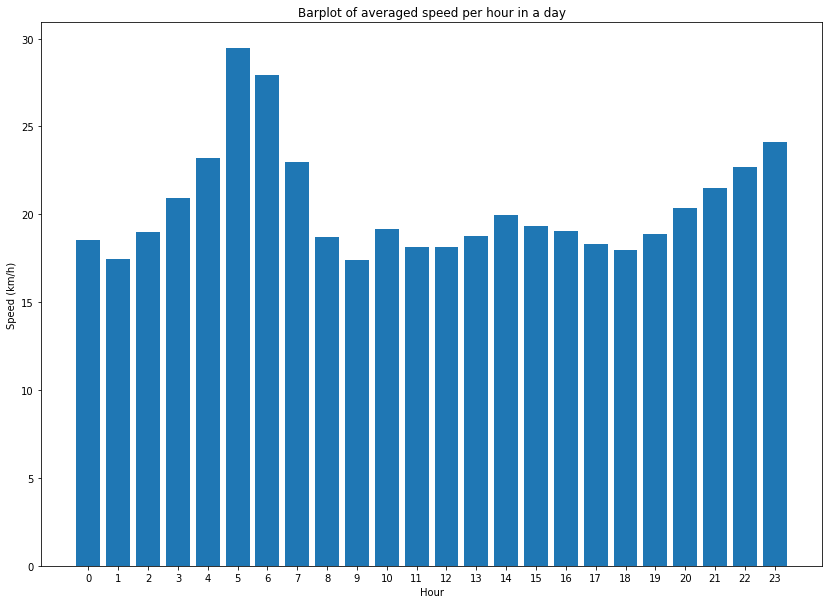

In [ ]:
import matplotlib.pyplot as plt

# Plot barplot
pdf = df_velocity.toPandas()
plt.figure(figsize=(14,10))
plt.bar(pdf.hour, height=pdf.kilometers_hour)
plt.xticks(range(0,24))
plt.title('Barplot of averaged speed per hour in a day')
plt.xlabel('Hour')
plt.ylabel('Speed (km/h)')
plt.show()

As it can be seen, the fastest hours are in the early morning, when there is not a lot of traffic. In the peak hours, the averaged speed is quite reduced due to the increased number of vehicles.

## 3.2 - Most Common taxi trips

The second study provides the most common taxi trips in January 2017.



### 3.2.1 - Count

At first moment it is employed the *count* method. The original DataFrame is grouped by the picked up location and dropped of location. Then we count the number of registers per trip (same origin and destination) and sorted them in descent order.

In [ ]:

# Query - Transformation
df_id_count = df.groupBy('PULocationID', 'DOLocationID')\
                .count().withColumnRenamed('count', 'Number of trips')\
                .sort(desc('Number of trips'))

# Initial time, just before first action
st = time.time()

# Print table - First action
df_id_count.show(10)

# Final time
t = time.time() - st

# Print rows and cols of obtained DataFrame
print_shape(df_id_count)

# Print measurements
print_time(t, n_taxis)

+------------+------------+---------------+
|PULocationID|DOLocationID|Number of trips|
+------------+------------+---------------+
|         264|         264|          14776|
|         237|         236|           3433|
|         236|         236|           3174|
|         236|         237|           3011|
|         230|         246|           2944|
|          79|          79|           2939|
|         237|         237|           2744|
|         239|         142|           2595|
|         239|         238|           2539|
|         142|         239|           2471|
+------------+------------+---------------+
only showing top 10 rows


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|16738   | 3       |
--------------------

TIME AND DATA
-----------------------------------------------
|Time (secs)                      | 4.18      |
-----------------------------------------------
|Data Processed (registers)       | 971010    |
--------------------------------------

### 3.2.2 - Map and Reduce
Besides *count method*, we wanted to perform the same operations with *Map Reduce*. The process is detailed in next lines.

The first step is obtaining a column which joins the origin ID with the destination ID. We can do it with a select in the original DataFrame of taxis.

In [ ]:
df_trips = df.select(concat(df.PULocationID, lit('-'), df.DOLocationID).alias('Trip'))
df_trips.show(10)

+-------+
|   Trip|
+-------+
|263-161|
|186-234|
|164-161|
| 236-75|
|249-234|
|  48-48|
| 186-36|
|162-161|
|  48-50|
| 140-74|
+-------+
only showing top 10 rows



Before applying **Map Reduce** algorithm, it is necessary to convert the DataFrame into a **rdd**. Then we can process the data calling two functions: 

*   **map**: iterating over the column *Trip*, each element is stored in a tuple occupying the first position. With this operation we are taking only the column text instead of a row (from two dimensions to one). We store a 1 as a value in each tuple to be able to count them in next part.

*   **reduceByKey**: now tuples with same key (same trip) are added, so the total number is reduced.

After this process, we sort the obtained list in descent order according to the values.





In [ ]:
trips_count = df_trips.rdd.map(lambda x: (x['Trip'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False)
trips_count.take(10)

[('264-264', 14776),
 ('237-236', 3433),
 ('236-236', 3174),
 ('236-237', 3011),
 ('230-246', 2944),
 ('79-79', 2939),
 ('237-237', 2744),
 ('239-142', 2595),
 ('239-238', 2539),
 ('142-239', 2471)]

A new DataFrame is created from the previous list.

In [ ]:
df_trips_mr = trips_count.toDF(['Trip', 'Number of trips']).sort(desc('Number of trips'))
df_trips_mr.show(10)

+-------+---------------+
|   Trip|Number of trips|
+-------+---------------+
|264-264|          14776|
|237-236|           3433|
|236-236|           3174|
|236-237|           3011|
|230-246|           2944|
|  79-79|           2939|
|237-237|           2744|
|239-142|           2595|
|239-238|           2539|
|142-239|           2471|
+-------+---------------+
only showing top 10 rows



In order to get the same result than with the method *count*, the columns are splitted to recover the original form.

In [ ]:
split_col = split(df_trips_mr['Trip'], '-')
df_id_mr = df_trips_mr.select(split_col.getItem(0).alias('PULocationID'), split_col.getItem(1).alias('DOLocationID'), 'Number of trips')
df_id_mr.show(10)

+------------+------------+---------------+
|PULocationID|DOLocationID|Number of trips|
+------------+------------+---------------+
|         264|         264|          14776|
|         237|         236|           3433|
|         236|         236|           3174|
|         236|         237|           3011|
|         230|         246|           2944|
|          79|          79|           2939|
|         237|         237|           2744|
|         239|         142|           2595|
|         239|         238|           2539|
|         142|         239|           2471|
+------------+------------+---------------+
only showing top 10 rows



Now we can implement the whole process into one cell in order to compare the performance with the previous section. Take into account the time is measured until the number of trips are obtained, since splitting the DataFrame is not required for our goal.

In [ ]:
# Query - Transformation
df_trips = df.select(concat(df.PULocationID, lit('-'), df.DOLocationID).alias('Trip'))

# Initial time, just before first action
st = time.time()

# Map and Reduce - First action
trips_count = df_trips.rdd.map(lambda x: (x['Trip'], 1)).reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], False)

# Convert list to DataFrame
df_trips_mr = trips_count.toDF(['Trip', 'Number of trips']).sort(desc('Number of trips'))

# Final time
t = time.time() - st

# Split columns to obtain original form
split_col = split(df_trips_mr['Trip'], '-')
df_id_mr = df_trips_mr.select(split_col.getItem(0).alias('PULocationID'), split_col.getItem(1).alias('DOLocationID'), 'Number of trips')

# Print table
df_id_mr.show(10)

# Print rows and cols of obtained DataFrame
print_shape(df_id_mr)

# Print measurements
print_time(t, n_taxis)

+------------+------------+---------------+
|PULocationID|DOLocationID|Number of trips|
+------------+------------+---------------+
|         264|         264|          14776|
|         237|         236|           3433|
|         236|         236|           3174|
|         236|         237|           3011|
|         230|         246|           2944|
|          79|          79|           2939|
|         237|         237|           2744|
|         239|         142|           2595|
|         239|         238|           2539|
|         142|         239|           2471|
+------------+------------+---------------+
only showing top 10 rows


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|16738   | 3       |
--------------------

TIME AND DATA
-----------------------------------------------
|Time (secs)                      | 7.82      |
-----------------------------------------------
|Data Processed (registers)       | 971010    |
--------------------------------------

Time is longer than with the *count* method. It has been also tested measuring the time before converting the list of map and reduce, and the result is almost the same. Due to that, we can confirm first method is faster.

### 3.2.3 - Data visualization

Another barplot is employed to show the most commont trips in Janaury 2017. Selecting a number as *TOP*, it is printed in table format and in the barplot.

+-------+---------------+
|   Trip|Number of trips|
+-------+---------------+
|264-264|          14776|
|237-236|           3433|
|236-236|           3174|
|236-237|           3011|
|230-246|           2944|
|  79-79|           2939|
|237-237|           2744|
|239-142|           2595|
|239-238|           2539|
|142-239|           2471|
+-------+---------------+
only showing top 10 rows



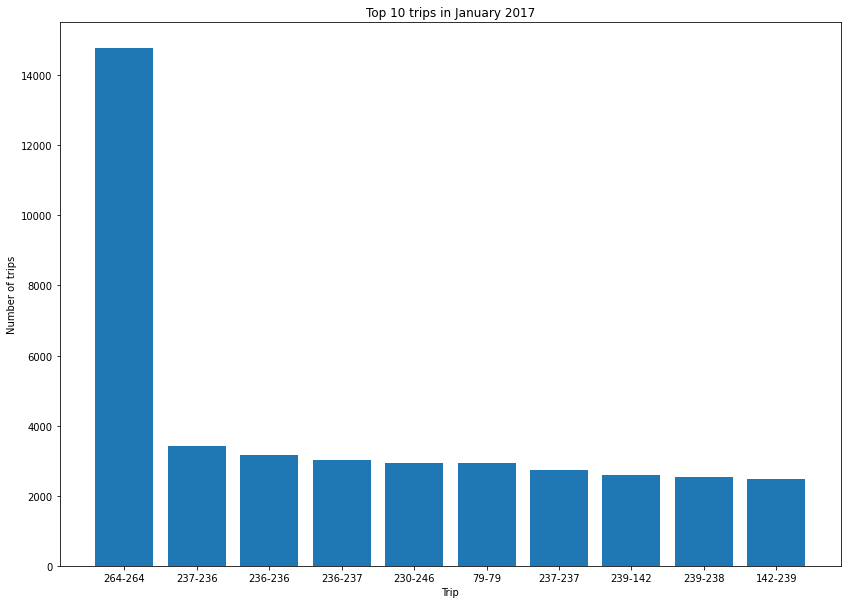

In [ ]:
#@title 
TOP = 10 #@param {type:"integer"}

# Print table
df_trips_mr.show(10)

# Plot barplot
pdf = df_trips_mr.limit(TOP).toPandas()
plt.figure(figsize=(14,10))
plt.bar(pdf.Trip, height=pdf['Number of trips'])
plt.xticks(range(0,TOP))
plt.title(f'Top {TOP} trips in January 2017')
plt.ylabel('Number of trips')
plt.xlabel('Trip')
plt.show()

### 3.2.4 - Translating Zones IDs

In this part we employed both datasets to match the zone ID with the corresponding area in text format. In section 2.2 it is obtained the concatenated DataFrame of the 265 possible locations.



In [ ]:
df_concat_zones.show(10, False)
df_concat_zones.count()
print_shape(df_concat_zones)

+----------+--------------------------------------+
|LocationID|Location                              |
+----------+--------------------------------------+
|1         |Newark Airport, EWR                   |
|2         |Jamaica Bay, Queens                   |
|3         |Allerton/Pelham Gardens, Bronx        |
|4         |Alphabet City, Manhattan              |
|5         |Arden Heights, Staten Island          |
|6         |Arrochar/Fort Wadsworth, Staten Island|
|7         |Astoria, Queens                       |
|8         |Astoria Park, Queens                  |
|9         |Auburndale, Queens                    |
|10        |Baisley Park, Queens                  |
+----------+--------------------------------------+
only showing top 10 rows


SHAPE
--------------------
|Rows    | Columns | 
--------------------
|265     | 2       |
--------------------


In order to match both datasets, it is applied a SQL query in a pipeline.

1.   Joining the DataFrame with the number of trips with the concatenated DataFrame of the taxi zones, macthing *PULocationID* and the *LocationID*.
2.   Selecting the *PULocationID* and the location from the taxi zones. Also the *DOLocationID* and the number of trips.

Now the process is repeated but in this case matching the *DOLocationID* with the *LocationID*. It is necessary to perform these two joins separately in order to avoid ambiguity problems with the *LocationID* of the taxi zones DataFrame.





In [ ]:
# Query - Transformation
df_id_zone_count = df_id_mr.join(df_concat_zones, 
                                   df_id_mr.PULocationID == df_concat_zones.LocationID) \
                             .select('PULocationID', 
                                     df_concat_zones.Location.alias('PULocation'),
                                     'DOLocationID',
                                     'Number of trips')\
                             .join(df_concat_zones, 
                                   df_id_mr.DOLocationID == df_concat_zones.LocationID)\
                             .select('PULocationID', 
                                     'PULocation',
                                     'DOLocationID',
                                     df_concat_zones.Location.alias('DOLocation'),
                                     'Number of trips')

# Initial time, just before first action
st = time.time()         

# Print table - First action               
df_id_zone_count.show(10, False)

# Final time
t = time.time() - st

# Print rows and cols of obtained DataFrame
print_shape(df_id_zone_count)

# Print measurements
print_time(t, df_id_mr.count())

+------------+------------------------------------+------------+------------------------------------+---------------+
|PULocationID|PULocation                          |DOLocationID|DOLocation                          |Number of trips|
+------------+------------------------------------+------------+------------------------------------+---------------+
|264         |NV, Unknown                         |264         |NV, Unknown                         |14776          |
|237         |Upper East Side South, Manhattan    |236         |Upper East Side North, Manhattan    |3433           |
|236         |Upper East Side North, Manhattan    |236         |Upper East Side North, Manhattan    |3174           |
|236         |Upper East Side North, Manhattan    |237         |Upper East Side South, Manhattan    |3011           |
|230         |Times Sq/Theatre District, Manhattan|246         |West Chelsea/Hudson Yards, Manhattan|2944           |
|79          |East Village, Manhattan             |79   

## 3.3 - Classifier

In this section we implement a classifier that, knowing some of the attributes provided in the dataset we are using in this lab, predicts if the corresponing person/people left some tip or not, without taking care of the amount.

### 3.3.1 - Preprocessing data

First, we convert the column 'tip_amount' to a binary variable: 1 if that person left tip and 0 if not.

Then, we select the variables we will use to predict, which are:
* passenger_count
* trip_distance
* RatecodeID
* PULocationID
* DOLocationID
* payment_type
* fare_amount


In [ ]:
df_tree = df.withColumn('tip_amount', expr('CASE WHEN tip_amount > 0  THEN 1 ' +
           "ELSE 0 END"))
df_tree = df_tree.drop('tpep_pickup_datetime').drop('tpep_dropoff_datetime').drop('total_amount').drop('improvement_surcharge').drop('tolls_amount') \
              .drop('mta_tax').drop('extra').drop('store_and_fwd_flag').drop('VendorID')

After this, we need some preprocessing to create de Binary Tree Classifier. We have to indicate that now, the column 'tip_amount' is categorical variable and not numeric.

Another preprocessing needed is vectorizing the features. This is a particular requisite to apply machine learning in PySpark.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

stages = []

label_stringIdx = StringIndexer(inputCol = 'tip_amount', outputCol = 'label')
stages += [label_stringIdx]

assemblerInputs = ['passenger_count', 'trip_distance','RatecodeID', 'PULocationID','DOLocationID', 'payment_type', 'fare_amount']

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

Now, we are ready to separate between train and test data. We use the 70% of the rows to train the model and the other 30% is used to test the performance.

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(df_tree)
df_tree = pipelineModel.transform(df_tree)
selectedCols = ['label', 'features']
df_tree = df_tree.select(selectedCols)
df_tree.printSchema()

train, test = df_tree.randomSplit([0.7, 0.3], seed = 2018)
print(f"Training Dataset Count: {train.count()}")
print(f"Test Dataset Count: {test.count()}")

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)

Training Dataset Count: 679865
Test Dataset Count: 291145


### 3.3.2 - Building the model

With all the preprocessing already performed we can build our binary classification model. We use a **Decision Tree** with a maximun depth of 4 in order to avoid over-fitting.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Build the model
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 4)

# Initial time, just before first action
st = time.time()

# Train the model - First action 
dtModel = dt.fit(train)

# Predictions
predictions = dtModel.transform(test)

# Final time
t = time.time() - st

# Print measurements
print_time(t, train.count())


TIME AND DATA
-----------------------------------------------
|Time (secs)                      | 30.94     |
-----------------------------------------------
|Data Processed (registers)       | 679865    |
-----------------------------------------------
|Processing speed (registers/sec) | 21977.07  |
-----------------------------------------------


### 3.3.3 - Performance

The metric used to measure the performance of this classifier is the **Area Under the ROC curve (AUC)**. We also plot this ROC Curve using the method provided by scikit-learn.

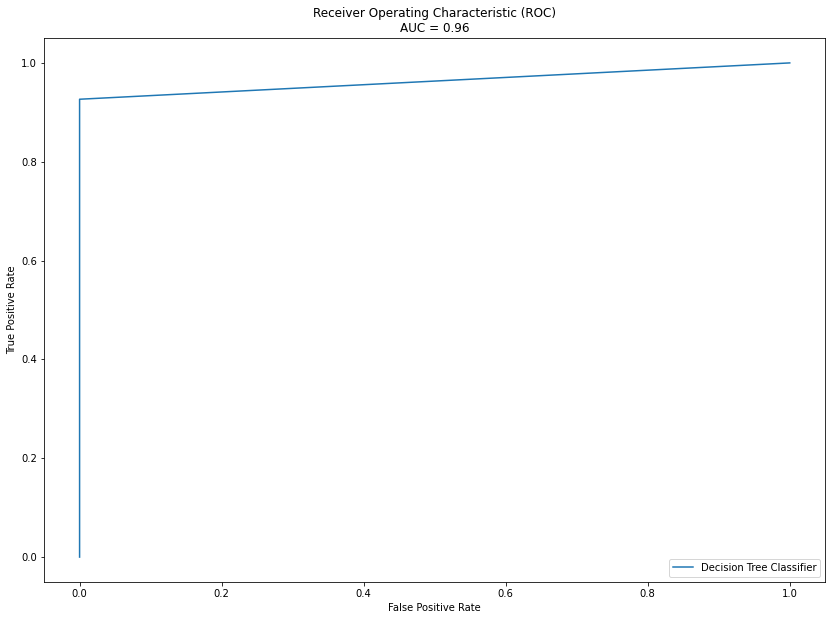

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

prs = predictions.select('probability').toPandas()
prs['probability'] = prs['probability'].str[1]
y_tst = test.select('label').toPandas()

# Calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_tst, prs)

# Plot the roc curve for the model
plt.figure(figsize=(14,10))
plt.plot(lr_fpr, lr_tpr, label='Decision Tree Classifier')
plt.title(f'Receiver Operating Characteristic (ROC)\nAUC = {auc:.2f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

After trying with different variables to predict if the passenger(s) were going to leave any tip, we concluded that the key variable used by the model is the *payment_type*. This makes sense, since the data dictionary says for the *tip_amount* column: "This field is automatically populated for credit card tips. Cash tips are not included."